In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats
from deepflow.plotting_utils import colorbar, load_folders, create_simulation_time_axis
from deepflow.plotting_utils import get_unconditionals, determine_connected
from deepflow.plotting_utils import plot_misfit_histograms, get_reference_curves, extract_curves
from deepflow.plotting_utils import inverse_permeability_transform, load_gt_model_from_numpy
from deepflow.plotting_utils import update_matplotlib_config

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Loading all the necessary data for the connectivity analysis

In [3]:
plot = False
working_dir = './results/runs/'
perm = "low_perm"

#Creates the simulation time axis
dts = create_simulation_time_axis()

#Load the ground truth case from the test set, corresponds to test set model 67
envelope = load_gt_model_from_numpy("./results/model_67_x.npy")

In [4]:
unc_curves, unc_poros, unc_perms, unc_zs, unc_misfits = get_unconditionals(working_dir, perm)
folders = [perm+a for a in ["/wells_adam_bce", "/flow_adam_bce", "/flowwells_adam_bce"]]

99
199
299
399
499
599
699
799
899
999


In [5]:
all_curves, all_poroperms, all_zs = load_folders(working_dir, folders, functionals=["min_map"]*3)

In [6]:
unc_props = np.concatenate([unc_poros.reshape(1000, 1, 64, 128), unc_perms.reshape(1000, 1, 64, 128)], 1)

In [7]:
#update_matplotlib_config()

# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

### Check if connected with and without dilation

In [8]:
dilation = False
connected_facies_unc = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in unc_props[0:100]] 
connected_facies_wells = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in all_poroperms[0][0]] 
connected_facies_flow = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in all_poroperms[1][0]] 
connected_facies_flow_wells = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in all_poroperms[2][0]]

dilation = True
connected_facies_unc_dl = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in unc_props[0:100]] 
connected_facies_wells_dl = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in all_poroperms[0][0]] 
connected_facies_flow_dl = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in all_poroperms[1][0]] 
connected_facies_flow_wells_dl = [determine_connected(np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1], dilation) for poro_perm in all_poroperms[2][0]] 

## Plot bar chart of number of models that are connected with/without dilation

[35, 51, 98, 100]


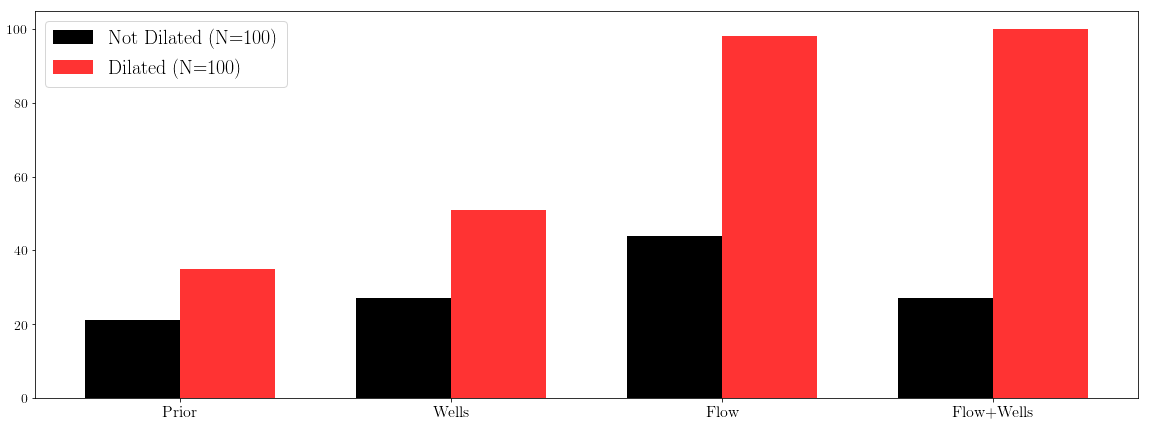

In [9]:
N = 4

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars

counts = [np.sum(c) for c in [connected_facies_unc,
          connected_facies_wells,
          connected_facies_flow,
          connected_facies_wells]]

p1 = ax.bar(ind, counts, width, color='black', bottom=0, yerr=None)

counts = [np.sum(c) for c in [connected_facies_unc_dl,
          connected_facies_wells_dl,
          connected_facies_flow_dl,
          connected_facies_flow_wells_dl]]

print(counts)

p2 = ax.bar(ind+width, counts, width, color='r', bottom=0, yerr=None, alpha=0.8)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Prior', 'Wells', 'Flow', 'Flow+Wells'), fontsize=16)

ax.legend((p1[0], p2[0]), ('Not Dilated (N=100)', 'Dilated (N=100)'), loc=0, fontsize=20)
ax.autoscale_view()
fig.tight_layout()
if plot:
    plt.savefig("./results/figures/connected_comparison.png", dpi=300, bbox_inches="tight")